importing Necessary Libraries

In [117]:
# !pip install yfinance

In [118]:
import yfinance as yf
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,Dropout,BatchNormalization,SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint

In [119]:
data = yf.download("RELIANCE.NS")
data.columns = data.columns.droplevel(1)
data.reset_index(inplace = True)
data.head()

[*********************100%***********************]  1 of 1 completed


Price,Date,Adj Close,Close,High,Low,Open,Volume
0,1996-01-01,3.619125,7.345901,7.358397,7.270925,7.319124,104121369
1,1996-01-02,3.590981,7.288776,7.363753,7.235222,7.328050,168743308
2,1996-01-03,3.618245,7.344116,7.745775,7.328050,7.408381,209323879
3,1996-01-04,3.584825,7.276280,7.297702,7.178097,7.274495,216900264
4,1996-01-05,3.560199,7.226296,7.247718,7.163816,7.247718,166708467


In [120]:
# data['MA50'] = data['Close'].rolling(50).mean()
# data['MA200'] = data['Close'].rolling(200).mean()
# data['EMA50'] = data['Close'].ewm(span = 50,adjust = False).mean()
# data['EMA200'] = data['Close'].ewm(span = 200,adjust = False).mean()

# def compute_rsi(data, window_length=14):
#     delta = data.diff()

#     gain = (delta.where(delta > 0, 0))
#     loss = (-delta.where(delta < 0, 0))

#     avg_gain = gain.rolling(window=window_length, min_periods=1).mean()
#     avg_loss = loss.rolling(window=window_length, min_periods=1).mean()
#     rs = avg_gain / avg_loss

#     rsi = 100 - (100 / (1 + rs))

#     return rsi

# data['RSI'] = compute_rsi(data['Close'])


**Purpose : To identify the trend whether the trend of stock price is positive or negative at current time.**

In [121]:
# def calculate_supertrend(data,period = 14,multiplier = 3):
#   data['H-L'] = data['High'] -data['Low']
#   data['H-PC'] = np.abs(data['High'] - data['Close'].shift())
#   data['L-PC'] = np.abs(data['Low'] - data['Close'].shift())
#   data['TR'] = 0
#   data['TR'] = data[['H-L','H-PC','L-PC','TR']].max(axis = 1)

#   data['ATR'] = data['TR'].rolling(period).mean()

#   data['Upperband'] =( data['High'] + data['Low'])/ 2 + (multiplier * data['ATR'])
#   data['Lowerband'] = (data['High'] + data['Low']) /2 - (multiplier * data['ATR'])

#   data['Supertrend'] = 0.0

#   for i in range(period,len(data)):
#     if data['Close'][i] > data['Supertrend'][i-1]:
#       data['Supertrend'][i] = data['Lowerband'][i]
#     else:
#       data['Supertrend'][i] = data['Upperband'][i]

#   return data


# data = calculate_supertrend(data)

**Purpose: Measures volatility and potential overbought/oversold conditions.**

In [122]:
# def compute_bolinger_bands(data,window = 20):
#   ma = data['Close'].rolling(window).mean()
#   std = data['Close'].rolling(window).std()
#   data['BB_Upper'] = ma + (2*std)
#   data['BB_Lower'] = ma + (2*std)

#   return data

# data = compute_bolinger_bands(data)
# data.head()

**Purpose: Combines price and volume to give a weighted average, providing insights into the true average price over a period.**

In [123]:
# def compute_vwap(data):
#   data['VWAP'] = (data['Close'] * data['Volume']).cumsum() / data['Volume'].cumsum()
#   return data

# data = compute_vwap(data)
# data.head()

**Purpose : Measures Momentum by comparing the closing price to range of prices over certain period**

In [124]:
# def compute_stochastic_oscilator(data,window = 14):
#   data['Lowest_low'] = data['Low'].rolling(window).min()
#   data['Highest_high'] = data['High'].rolling(window).max()

#   data['Stochastic_Oscilator'] = ((data['Close'] - data['Lowest_low']) / (data['Highest_high'] - data['Lowest_low']))*100

#   return data

# data = compute_stochastic_oscilator(data)
# data.head()

In [125]:
# On Balance Volume
# def compute_obv(data):
#   data['OBV'] = (np.sign(data['Close'].diff()) *  data['Volume']).cumsum()
#   return data

# data = compute_obv(data)
data.columns

Index(['Date', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object', name='Price')

In [126]:
data = data['Close']
data.head()

,Close
0,7.345901
1,7.288776
2,7.344116
3,7.276280
4,7.226296


In [127]:
data.isnull().sum()

0

In [128]:
# data.dropna(subset =['MA50','MA200'],inplace = True )

In [129]:
scaler = MinMaxScaler(feature_range=(0,1))
data = np.array(data)
data = scaler.fit_transform(data.reshape(-1,1))

In [130]:
train_size = int(len(data) * 0.8)
train_data = data[:train_size]
test_data = data[train_size:]

In [131]:
data.shape,train_data.shape,test_data.shape

((7269, 1), (5815, 1), (1454, 1))

In [132]:
time_step = 100
X_train = []
y_train = []

for i in range(time_step,len(train_data)):
  X_train.append(train_data[i-time_step:i])
  y_train.append(train_data[i,0])

X_train = np.array(X_train)
y_train = np.array(y_train)

In [133]:
X_train.shape,y_train.shape

((5715, 100, 1), (5715,))

In [134]:
time_step = 100
X_test = []
y_test = []

for i in range(time_step,len(test_data)):
  X_test.append(test_data[i-time_step:i])
  y_test.append(test_data[i,0])

X_test = np.array(X_test)
y_test = np.array(y_test)

In [135]:
X_test.shape,y_test.shape

((1354, 100, 1), (1354,))

In [136]:

model = Sequential()
model.add(tf.keras.layers.Input(shape = (X_train.shape[1],X_train.shape[2]) ))

# model.add(LSTM(256,return_sequences = True))
# model.add(tf.keras.layers.LayerNormalization())

model.add(LSTM(100,return_sequences = True ))
model.add(tf.keras.layers.LayerNormalization())


model.add(LSTM(100,return_sequences = True ))
model.add(tf.keras.layers.LayerNormalization())

model.add(LSTM(100,return_sequences = True ))
model.add(tf.keras.layers.LayerNormalization())

model.add(LSTM(128, ))
model.add(tf.keras.layers.LayerNormalization())

model.add(Dense(128,activation = 'relu'))
model.add(tf.keras.layers.BatchNormalization())
# model.add(Dropout(0.2))
# model.add(Dense(32,activation = 'relu'))
# model.add(tf.keras.layers.BatchNormalization())
# model.add(Dropout(0.2))
model.add(Dense(1))

In [137]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_15 (LSTM)                       │ (None, 100, 100)            │          40,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_15               │ (None, 100, 100)            │             200 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_16 (LSTM)                       │ (None, 100, 100)            │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_16               │ (None, 100, 100)            │             200 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_17 (LSTM)                       │ (None, 100, 100)            │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_17               │ (None, 100, 100)            │             200 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_18 (LSTM)                       │ (None, 128)                 │         117,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_18               │ (None, 128)                 │             256 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 336,857 (1.29 MB)

 Trainable params: 336,601 (1.28 MB)

 Non-trainable params: 256 (1.00 KB)

In [138]:
model.compile(optimizer = 'adam',loss = 'mean_squared_error',metrics = ['mse'])

In [139]:
checkpoint = ModelCheckpoint(
    "best_model.keras",
    monitor = "val_loss",
    mode = "min",
    save_best_only = True,
    save_weights_only = False,
    verbose = 1
)

In [140]:
# history = model.fit(X_train,y_train,epochs = 100,validation_data = (X_test,y_test),callbacks = [checkpoint])

In [141]:
from tensorflow.keras.models import load_model

model = load_model('best_model.keras')
# history = model.fit(X_train,y_train,epochs = 100,validation_data = (X_test,y_test),callbacks = [checkpoint])

In [142]:
test_prices = scaler.inverse_transform(y_test.reshape(-1,1))

In [143]:
test_prices

array([[ 577.12683105],
       [ 592.41900635],
       [ 591.6418457 ],
       ...,
       [1284.84997559],
       [1278.19995117],
       [1273.09997559]])

In [144]:

test_predictions = model.predict(X_test)
test_predictions = scaler.inverse_transform(test_predictions)


43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


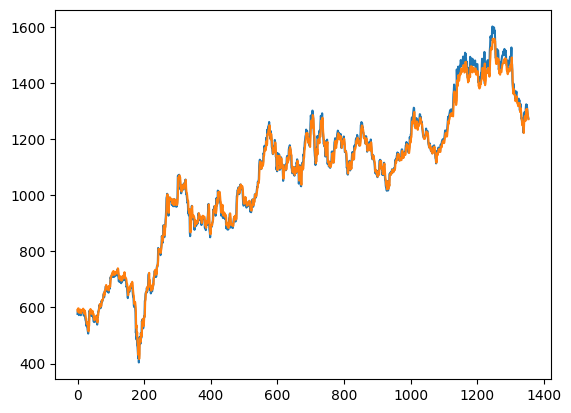

In [145]:
plt.plot(test_prices)
plt.plot(test_predictions)

In [146]:

train_predictions = model.predict(X_train)


train_predictions_rescaled = scaler.inverse_transform(train_predictions)

179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


In [147]:
train_predictions_rescaled

array([[  6.4780807],
       [  6.231894 ],
       [  6.1767454],
       ...,
       [523.1494   ],
       [523.3688   ],
       [543.0042   ]], dtype=float32)

In [148]:
y_train_rescaled = scaler.inverse_transform(y_train.reshape(-1,1))
y_train_rescaled

array([[  8.65263271],
       [  8.62228489],
       [  8.66869926],
       ...,
       [518.63238525],
       [541.44494629],
       [565.83477783]])

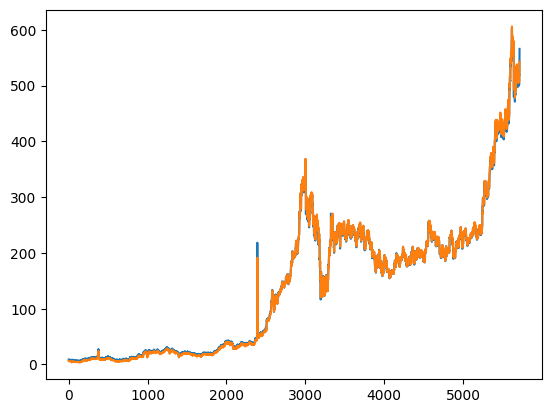

In [149]:
plt.plot(y_train_rescaled)
plt.plot(train_predictions_rescaled)



In [150]:
actual_close = scaler.inverse_transform(data)
actual_close

array([[   7.34590101],
       [   7.28877592],
       [   7.34411621],
       ...,
       [1284.84997559],
       [1278.19995117],
       [1273.09997559]])

In [167]:
lookback = 100
train_pred_aligned = np.empty_like(actual_close)
train_pred_aligned[:] = np.nan
train_pred_aligned[lookback:lookback + len(train_predictions_rescaled)] = train_predictions_rescaled

test_index_start = len(train_predictions_rescaled)+ lookback*2
test_pred_aligned = np.empty_like(actual_close)
test_pred_aligned[:] = np.nan
test_pred_aligned[test_index_start:test_index_start + len(test_predictions)] = test_predictions

In [159]:
len(actual_close),data.shape[0]

(7269, 7269)

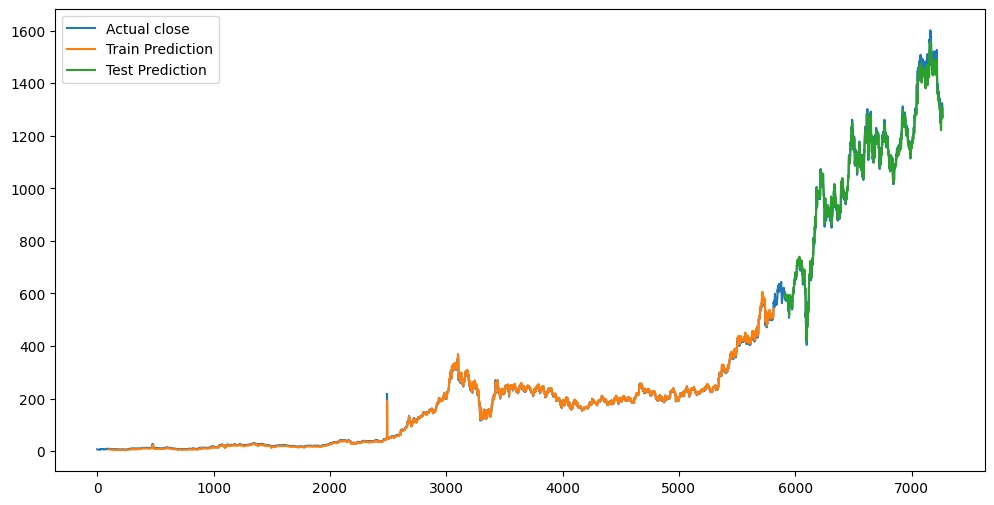

In [171]:
plt.figure(figsize = (12,6))
plt.plot(actual_close,label= "Actual close")
plt.plot(train_pred_aligned,label = "Train Prediction")
plt.plot(test_pred_aligned,label = "Test Prediction")
plt.legend()

In [155]:
actual_close[-1]

array([1273.09997559])

In [ ]:
def blend_predictions(predicted_price, historical_price, alpha=0.8):
    historical_price = historical_price[-1]  # Use the latest historical price
    return alpha * predicted_price + (1 - alpha) * historical_price


In [ ]:
def calculate_features(df):
  df['MA50'] = df['Close'].rolling(50).mean()
  df['MA200'] = df['Close'].rolling(200).mean()
  df['EMA50'] = df['Close'].ewm(span = 50,adjust = False).mean()
  df['EMA200'] = df['Close'].ewm(span = 200,adjust = False).mean()

  return df

In [156]:
X_test[-1].shape

(100, 1)

In [177]:
import pandas as pd
import numpy as np

input_data = X_test[-1]
predicted_prices = []

for i in range(200):

  input_sequence = input_data.reshape(1, 100, 1)

  next_close_price = model.predict(input_sequence, verbose=0)[0, 0]

  next_close_price_original = scaler.inverse_transform([[next_close_price]])[0,0]

  predicted_prices.append(next_close_price_original)

  input_data = np.roll(input_data,-1)


  input_data[-1] = next_close_price

  # print(f"Step {i+1}, Predicted: {next_close_price_original}")






In [185]:
def exponential_moving_average(data, span):
    return pd.Series(data).ewm(span=span, adjust=False).mean()

# Apply EMA to predicted prices
smoothed_predictions = exponential_moving_average(predicted_prices, span=10)  # Adjust span as needed


In [186]:
smoothed_predictions

,0
0,1270.627935
1,1269.353848
2,1267.114302
3,1264.149116
4,1260.647076
...,...
195,1084.537190
196,1084.516663
197,1084.496843
198,1084.476857


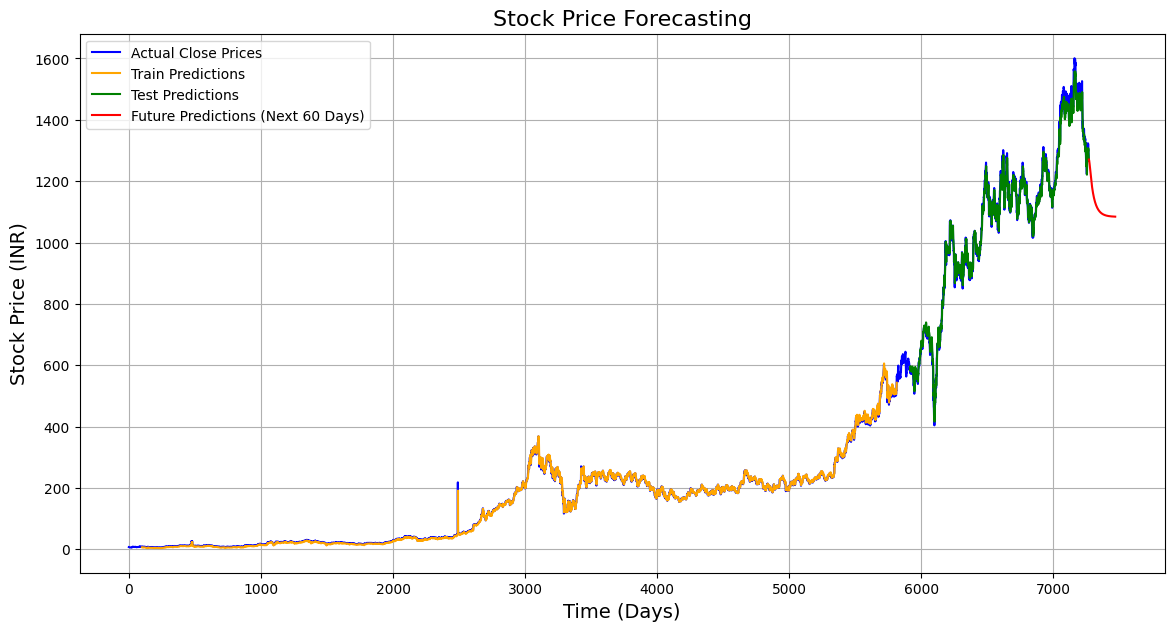

In [187]:
import matplotlib.pyplot as plt
import numpy as np

# Create x-axis values for each part
x_actual = np.arange(len(actual_close))
x_train = np.arange(lookback, lookback + len(train_pred_aligned))
x_test = np.arange(test_index_start, test_index_start + len(test_pred_aligned))
x_predicted = np.arange(len(actual_close), len(actual_close) + len(predicted_prices))
# x_predicted = np.arange(len(actual_close), len(actual_close) + len(predicted_prices))

# Plotting the data
plt.figure(figsize=(14, 7))

# Plot actual close prices
plt.plot(actual_close, label='Actual Close Prices', color='blue')

# Plot train predictions
plt.plot(train_pred_aligned, label='Train Predictions', color='orange')

# Plot test predictions
plt.plot(test_pred_aligned, label='Test Predictions', color='green')

# Plot future predicted prices
plt.plot(x_predicted,smoothed_predictions, label='Future Predictions (Next 60 Days)', color='red')

# Title and labels
plt.title("Stock Price Forecasting", fontsize=16)
plt.xlabel("Time (Days)", fontsize=14)
plt.ylabel("Stock Price (INR)", fontsize=14)

# Display legend
plt.legend()

# Show grid for better readability
plt.grid(True)

# Display the plot
plt.show()


In [ ]:
predicted_prices

In [ ]:
X_test.shape